# Project-008-2 Heart Disease 

### Predicting Heart Disease Diagnosis

### Introduction 

The cardiovascular system encompasses an intricate network of blood vessels, including veins, arteries, and capillaries, which facilitate the circulation of blood throughout the body. Any disruptions in the flow of blood emanating from the heart can lead to various forms of heart diseases, collectively referred to as cardiovascular or heart diseases. Globally, heart diseases constitute a leading cause of mortality - the World Health Organization (WHO) indicates that approximately 17.5 million deaths annually are attributable to heart attacks and strokes. Consequently, the early detection of cardiac anomalies is imperative as it can significantly save lives and assist healthcare professionals in crafting effective treatment strategies. 

In this study, we will examine a dataset that contains test results from 303 patients referred for coronary angiography at the Cleveland Clinic in Ohio between May 1981 and September 1984. All the patients had similar medical profiles and underwent the same non-invasive tests, namely, exercise electrocardiogram, exercise thallium scintigraphy and fluoroscopy for coronary calcium. 

The clinical and test variables included in this dataset are per the below, while the target variable is the angiographic disease status `num`, where the value 0 corresponds to the major vessels show less than 50% narrowing of the vessels diameter while the values 1 and more correspond to showing greater than 50% narrowing of the vessels diameter.

The variables represent the following <br>
**Demographic Information:**
- Age (`age`)
- Sex (`sex`)
    - 1 = Male
    - 0 = Female

**Clinical Information:**
- Chest Pain Type (`cp`)
    - 1 = Typical Anginal
    - 2 = Atypical Anginal
    - 3 = Nonanginal
    - 4 = Asymptomatic
- Systolic Blood Pressure (`trestbps`) - in mmHg on admission to the hospital

**Routine Test Data Collected:**
- Serum Cholesterol Determination (`chol`) - in mg/dl
- Fasting Blood Sugar Determination (`fbs`) - fasting blood sugar > 120 mg/dl)
    - 1 = True
    - 0 = False
- Resting Electrocardiographic Results (`restecg`)
    - 0 = Normal
    - 1 = Having ST-T Wave Abnormality
    - 2 = Showing Probable or Definite Left Ventricular Hypertrophy by Estes’ Criteria

**Exercise Test Data Collected:**
- Maximum Heart Rate Achieved (`thalach`) - in beats per minute
- Exercise Induced Angina (`exang`)
    - 1 = Yes
    - 0 = No
- ST Depression Induced by Exercise Relative to Rest (`oldpeak`)
- Slope of the Peak Exercise ST Segment (`slope`)
    - 1 = Upsloping
    - 2 = Flat
    - 3 = Downsloping

**Other Non-invasive Test Data Collected:**
- Number of Major Vessels Colored by Fluoroscopy for Coronary Calcium (`ca`) - 0 to 3
- Exercise Thallium Scintigraphy Results (`thal`)
    - 3 = Normal
    - 6 = Fixed Defect
    - 7 = Reversible Defect


In this study, we will address the predictive question: can we use clinical and test data available to us to predict a diagnosis of heart disease. This is important as it provides a quick and data-driven method to diagnose heart disease and eliminates subjectivity and dependence on the skill and experience of the diagnosing physician. 

Therefore we decided to define that we can use clinical and test data to predict a diagnosis of heart
disease when the accuracy is greater than 50%. When the accuracy is lower 50% we cannot use it to predict.

### Methods and Results

Describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
your report should include code which:
- loads data from the original source on the web - DONE
- wrangles and cleans the data from it's original (downloaded) format to the -format necessary for the planned analysis - DONE
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis - 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 
- note: all tables and figure should have a figure/table number and a legend

In [16]:
install.packages("kknn")
install.packages("GGally")
library(tidyverse)
library(repr)
library(tidymodels)
library(kknn)
library(GGally)
library(dplyr)
options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [17]:
heart_disease <- read_csv("https://raw.githubusercontent.com/Mikeee12138/Group-Project-dsci100/main/processed.cleveland.data", col_names = FALSE)
colnames(heart_disease) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
heart_disease

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


The dataset appears to be clean and wrangled into a tidy format with the addition of the column headers. 
However, the two columns `ca` and `thal` appear to contain missing values signified by a "?" character. We shall filter the training dataset so that all the rows with missing values are eliminated. We will also change the type of the `ca` variable from to numeric so we can use numeric analysis methods on it and we will convert the categorical variable `num` into a factor.

In [18]:
heart_disease_filtered <- heart_disease |>
    filter(ca != "?", thal != "?") |> 
    mutate(ca = as.numeric(ca), num = as_factor(num))

heart_disease_filtered

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2,7.0,2
57,1,4,130,131,0,0,115,1,1.2,2,1,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1,3.0,1


Our categorical variable `num` is already factorized. However, since the intention of our analysis is to predict whether the target value is 0, signifying <50% of diameter narrowing in the major vessels (i.e., no heart disease) or not, we can assign the non-zero values to the value 1. This is done to improve the accuracy of our classification since all other values imply heart disease at different extents but our prediction is strictly concerned with its existence.

In [19]:
heart_disease_filtered['num'][heart_disease_filtered['num'] == '2'] <- '1'
heart_disease_filtered['num'][heart_disease_filtered['num'] == '3'] <- '1'
heart_disease_filtered

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2,7.0,1
57,1,4,130,131,0,0,115,1,1.2,2,1,7.0,1
57,0,2,130,236,0,2,174,0,0.0,2,1,3.0,1


As part of the exploratory data analysis, we will split the data into a training and test set, with `num` being the variable we want to classify.

In [20]:
heart_disease_split <- initial_split(heart_disease_filtered , prop = 0.75, strata = num) 
    heart_disease_train <- training(heart_disease_split)   
    heart_disease_test<- testing(heart_disease_split)
    heart_disease_train

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0
37,1,3,130,250,0,0,187,0,3.5,3,0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2,7.0,1
57,1,4,130,131,0,0,115,1,1.2,2,1,7.0,1
57,0,2,130,236,0,2,174,0,0.0,2,1,3.0,1


Using only the observations in the training data set, use the ggpairs library create a pairplot of all the columns we are interested in including in our model.

In [27]:
heart_disease_train_predict <- select(heart_disease_train, age, trestbps, chol, thalach, oldpeak, ca, num)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)

  heart_disease_pairplot <- heart_disease_train_predict |> 
      ggpairs(
          lower = list(continuous = wrap('points', alpha = 0.4)),
          diag = list(continuous = "barDiag")
      ) +
      theme(text = element_text(size = 20))
heart_disease_pairplot 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


In [22]:
#added recipe
heart_disease_recipe_1 <- recipe(num ~ age + trestbps + chol , data = heart_disease_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
heart_disease_recipe_1

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [8]:
#added model
heart_disease_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")


In [9]:
#cross validation with v = 5
heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = num)

In [10]:
#set up possible values of k
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

In [11]:
#finding accuracies
knn_results <- workflow() |>
      add_recipe(heart_disease_recipe_1) |>
       add_model(heart_disease_spec) |>
       tune_grid(resamples = heart_disease_vfold, grid = k_vals) |>
       collect_metrics()

! Fold1: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '2', '3'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 19 ...

! Fold2: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '2', '3'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 19 ...

! Fold3: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s)

In [12]:
#filtering for only accuracy
accuracies <- knn_results |> 
       filter(.metric == "accuracy")
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4780973,5,0.04818798,Preprocessor1_Model01
2,accuracy,multiclass,0.4780973,5,0.04818798,Preprocessor1_Model02
3,accuracy,multiclass,0.5358656,5,0.02638272,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
18,accuracy,multiclass,0.5584050,5,0.03644833,Preprocessor1_Model18
19,accuracy,multiclass,0.5673996,5,0.04234487,Preprocessor1_Model19
20,accuracy,multiclass,0.5812427,5,0.03190993,Preprocessor1_Model20


In [13]:
#finding max accuracy
max_accuracies <- summarize(accuracies, accuracy = max(mean))

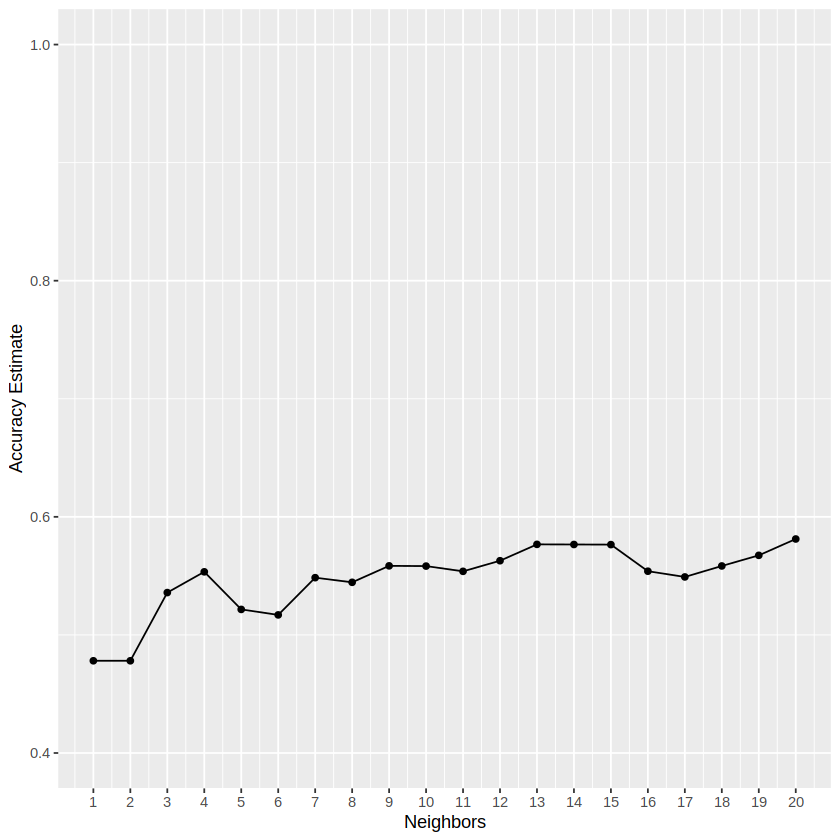

In [14]:
#plotting accuracy
options(repr.plot.width = 7, repr.plot.height = 7)
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(1, 20, by = 1)) +  
       scale_y_continuous(limits = c(0.4, 1.0)) 
accuracy_versus_k

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

! Fold1: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '2', '3'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 19 ...

! Fold2: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '2', '3'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 19 ...

! Fold3: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.5761640,5,0.02246449,Preprocessor1_Model01
2,accuracy,multiclass,0.5718205,5,0.02247198,Preprocessor1_Model02
3,accuracy,multiclass,0.6673174,5,0.03253256,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
18,accuracy,multiclass,0.6905638,5,0.05186811,Preprocessor1_Model18
19,accuracy,multiclass,0.6814682,5,0.05041414,Preprocessor1_Model19
20,accuracy,multiclass,0.6813672,5,0.04072068,Preprocessor1_Model20


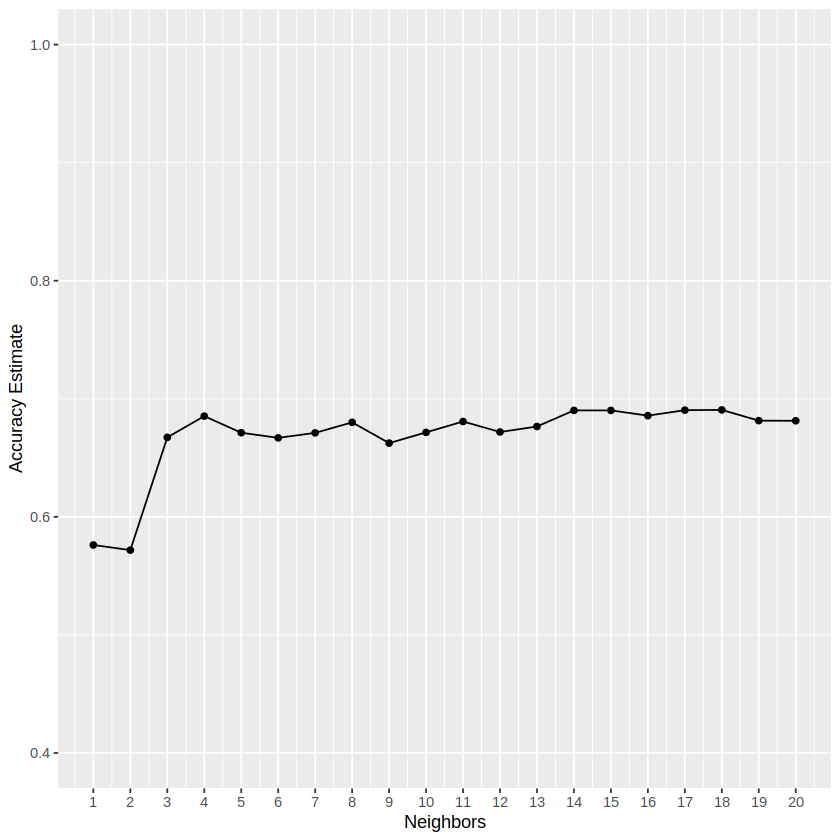

In [15]:
heart_disease_recipe_2 <- recipe(num ~ thalach + oldpeak  , data = heart_disease_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 
heart_disease_recipe_2


heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = num)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_results <- workflow() |>
      add_recipe(heart_disease_recipe_2) |>
       add_model(heart_disease_spec) |>
       tune_grid(resamples = heart_disease_vfold, grid = k_vals) |>
       collect_metrics()

accuracies <- knn_results |> 
       filter(.metric == "accuracy")
accuracies

max_accuracies <- summarize(accuracies, accuracy = max(mean))

options(repr.plot.width = 7, repr.plot.height = 7)
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(1, 20, by = 1)) + 
       scale_y_continuous(limits = c(0.4, 1.0)) 
accuracy_versus_k

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Scaling for all_predictors()
Centering for all_predictors()

! Fold1: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '2', '3'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 19 ...

! Fold2: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '2'...
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 19 ...

! Fold3: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.5449565,5,0.004803576,Preprocessor1_Model01
2,accuracy,multiclass,0.5495020,5,0.022120393,Preprocessor1_Model02
3,accuracy,multiclass,0.5407188,5,0.014899936,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
18,accuracy,multiclass,0.6305262,5,0.01967615,Preprocessor1_Model18
19,accuracy,multiclass,0.6305262,5,0.01967615,Preprocessor1_Model19
20,accuracy,multiclass,0.6305262,5,0.01967615,Preprocessor1_Model20


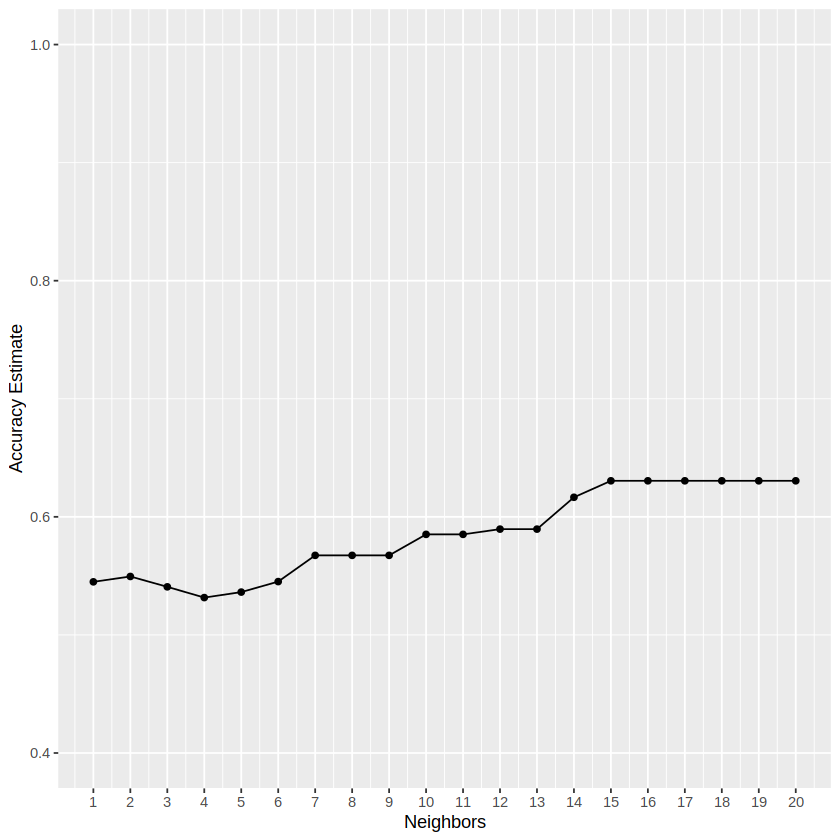

In [16]:
heart_disease_recipe_3 <- recipe(num ~ ca , data = heart_disease_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 
heart_disease_recipe_3

heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = num)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_results <- workflow() |>
      add_recipe(heart_disease_recipe_3) |>
       add_model(heart_disease_spec) |>
       tune_grid(resamples = heart_disease_vfold, grid = k_vals) |>
       collect_metrics()

accuracies <- knn_results |> 
       filter(.metric == "accuracy")
accuracies

max_accuracies <- summarize(accuracies, accuracy = max(mean))

options(repr.plot.width = 7, repr.plot.height = 7)
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(1, 20, by = 1)) + 
       scale_y_continuous(limits = c(0.4, 1.0)) 
accuracy_versus_k

In [17]:
knn_spec_1 <- nearest_neighbor(weight_func = "rectangular", neighbors = 20) |>
  set_engine("kknn") |>
  set_mode("classification")
knn_spec_1

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 20
  weight_func = rectangular

Computational engine: kknn 


In [18]:
knn_fit_1 <- workflow() |>
  add_recipe(heart_disease_recipe_1) |>
  add_model(knn_spec_1) |>
  fit(data = heart_disease_train)
knn_fit_1

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(20,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4504505
Best kernel: rectangular
Best k: 20

In [19]:
heart_disease_test_predictions_1 <- predict(knn_fit_1, heart_disease_test) |>
  bind_cols(heart_disease_test)|>
  metrics(truth = num, estimate = .pred_class) |>
  filter(.metric == "accuracy")

heart_disease_test_predictions_1

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5733333


In [20]:
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
  set_engine("kknn") |>
  set_mode("classification")
knn_spec_2

knn_fit_2 <- workflow() |>
  add_recipe(heart_disease_recipe_2) |>
  add_model(knn_spec_2) |>
  fit(data = heart_disease_train)
knn_fit_2

heart_disease_test_predictions_2 <- predict(knn_fit_2, heart_disease_test) |>
  bind_cols(heart_disease_test)|>
  metrics(truth = num, estimate = .pred_class) |>
  filter(.metric == "accuracy")

heart_disease_test_predictions_2

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 17
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(17,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3153153
Best kernel: rectangular
Best k: 17

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6666667


In [21]:
knn_spec_3 <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
  set_engine("kknn") |>
  set_mode("classification")
knn_spec_3

knn_fit_3 <- workflow() |>
  add_recipe(heart_disease_recipe_3) |>
  add_model(knn_spec_3) |>
  fit(data = heart_disease_train)
knn_fit_3

heart_disease_test_predictions_3 <- predict(knn_fit_3, heart_disease_test) |>
  bind_cols(heart_disease_test)|>
  metrics(truth = num, estimate = .pred_class) |>
  filter(.metric == "accuracy")

heart_disease_test_predictions_3

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 13
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(13,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4324324
Best kernel: rectangular
Best k: 13

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5733333
